#  Введение в рекуррентные нейронные сети

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html
* https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Задачи для совместного разбора

1\. Рассмотрите пример работы одного шага простейшего рекуррентного слоя.  

$$ h' = tanh(W_{ih}x + W_{hh}h) $$

![RNN](https://kvitajakub.github.io/img/rnn-unrolled.png)

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
batch_size = 16
seq_len = 8
embedding_dim = 32
hidden_dim = 10

x = th.rand(batch_size, seq_len, embedding_dim)

cell = nn.RNNCell( # A
    input_size=embedding_dim,
    hidden_size=hidden_dim
)

In [ ]:
for s in range(seq_len):
  x_i = x[:, s, :]
  h = cell(x_i, h)
  break

In [ ]:
h.shape

torch.Size([16, 10])

2\. Рассмотрите пример работы рекуррентных слоев из `torch.nn`.

In [ ]:
batch_size = 16
seq_len = 8
embedding_dim = 32
hidden_dim = 10

x = th.rand(batch_size, seq_len, embedding_dim)

In [ ]:
layer = nn.RNN(
    input_size=embedding_dim,
    hidden_size=hidden_dim,
    batch_first=True,
)

In [ ]:
o, h = layer(x)

In [ ]:
o.shape

torch.Size([16, 8, 10])

In [ ]:
h.shape

torch.Size([1, 16, 10])

In [ ]:
o[0, -1, :]

tensor([-0.6032,  0.6322,  0.9111,  0.8633, -0.7067, -0.9742,  0.6296,  0.7313,
         0.2136, -0.1802], grad_fn=<SliceBackward0>)

In [ ]:
h[0, 0]

tensor([-0.6032,  0.6322,  0.9111,  0.8633, -0.7067, -0.9742,  0.6296,  0.7313,
         0.2136, -0.1802], grad_fn=<SelectBackward0>)

In [ ]:
x1 = x.permute(1, 0, 2)
x1.shape

torch.Size([8, 16, 32])

## Задачи для самостоятельного решения

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
import torch.optim as optim

import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

<p class="task" id="1"></p>

1\. Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Предусмотрите возможность работы с двумя вариантами данных: где данные (x) представлены в виде (batch, seq, feature) и где данные представлены в формате (seq, batch, feature). Создайте тензор `x1` размера 16 x 8 x 32 (batch, seq, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[-1]` поэлементно равен `h`.

- [ ] Проверено на семинаре

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, batch_first=True):
    super().__init__()
    self.hidden_size = hidden_size
    self.rnn_cell = nn.RNNCell(input_size, hidden_size)
    self.batch_first = batch_first

  def forward(self, x, h=None):
    '''
    x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
    h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
    '''
    if not self.batch_first:
      x = x.permute(1, 0, 2)
    if h is None:
      h = torch.zeros(x.size(0), self.hidden_size, dtype=torch.float32)
    hidden_states = []

    for seq in range(x.size(1)):
      h = self.rnn_cell(x[:, seq, :], h)
      hidden_states.append(h)

    hidden_states = torch.stack(hidden_states, dim=1)

    return hidden_states, h

In [ ]:
x1 = torch.rand(16, 8, 32)
rnn_model = RNN(input_size=32, hidden_size=64)
output, h = rnn_model(x1)

In [ ]:
output.shape

torch.Size([16, 8, 64])

In [ ]:
h.shape

torch.Size([16, 64])

In [ ]:
if torch.equal(output[:, -1, :], h):
  print('тензор output[-1] поэлементно равен h')
else:
  print('тензор output[-1] поэлементно не равен h')

тензор output[-1] поэлементно равен h


<p class="task" id="2"></p>

2\. Создайте тензор `x2` размера 8 x 16 x 32 (seq, batch, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[-1]` поэлементно равен `h`.

- [ ] Проверено на семинаре

In [ ]:
x2_batch_second = torch.rand(8, 16, 32)
rnn_model_batch_second = RNN(input_size=32, hidden_size=64, batch_first=False)
output, h = rnn_model_batch_second(x2_batch_second)

In [ ]:
output.shape

torch.Size([16, 8, 64])

In [ ]:
h.shape

torch.Size([16, 64])

In [ ]:
if torch.equal(output[:, -1, :], h):
  print('тензор output[-1] поэлементно равен h')
else:
  print('тензор output[-1] поэлементно не равен h')

тензор output[-1] поэлементно равен h


<p class="task" id="3"></p>

3\. Считайте файл `pets.csv`, приведите имена питомцев к нижнем регистру. Решите проблему с противоречивостью данных (некоторые имена встречаются в обоих классах). Разбейте набор данных на обучающую и тестовую выборку.  Создайте Vocab на основе обучающей выборки (токен - __буква__). Добавьте в словарь специальный токен `<PAD>`. Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NLP/data/pets.csv')
data.head()

,имя,класс
0,Арчи,собака
1,Алекс,собака
2,Амур,собака
3,Алтaй,собака
4,Альф,собака


In [ ]:
data.shape

(3228, 2)

In [ ]:
data['имя'] = data['имя'].str.lower()

In [ ]:
data = data.drop_duplicates(subset=['имя'])
data.shape

(2792, 2)

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
vocab = build_vocab_from_iterator(train_df['имя'].tolist(), specials=['<PAD>', '<UNK>'])
vocab.set_default_index(1) # <UNK>

In [ ]:
len(vocab)

37

<p class="task" id="4"></p>

4\. Создайте класс `PetsDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами классы питомцев. Создайте два объекта класса `PetsDataset` (для обучающей и тестовой выборки). Выведите на экран их длины.

- [ ] Проверено на семинаре

In [ ]:
class PetsDataset(Dataset):
    def __init__(self, dataframe, vocab, max_length=15):
        self.data = dataframe
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        name = self.data.iloc[index]['имя']
        if isinstance(name, str):
            name = [name]
            animal = pd.Series(self.data.iloc[index]['класс']).replace(['собака', 'кошка'], [0, 1]).tolist()
        else:
            name = name.tolist()
            animal = self.data.iloc[index]['класс'].replace(['собака', 'кошка'], [0, 1]).tolist()
        lst = []
        for i in range(len(name)):
            tokens = name[i].lower()
            indices = self.vocab.lookup_indices([token for token in tokens])
            indices = indices[:self.max_length]
            indices += [0] * (self.max_length - len(indices))
            indices = torch.tensor(indices)
            lst.append((indices, animal[i]))
        if len(lst) == 1:
            return lst[0]
        return lst

In [ ]:
train_dataset = PetsDataset(train_df, vocab)
test_dataset = PetsDataset(test_df, vocab)

print(train_dataset[0])
print(train_dataset[:3])

(tensor([23, 10,  6, 20,  9,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]), 1)
[(tensor([23, 10,  6, 20,  9,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]), 1), (tensor([17,  5, 10,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), 1), (tensor([25, 10,  4, 11, 10,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0]), 0)]


In [ ]:
len(train_dataset)

2233

In [ ]:
len(test_dataset)

559

<p class="task" id="5"></p>

5\. Используя созданный класс `RNN`, решите задачу классификации категорий питомцев по их именам. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [ ]:
classes = len(data['класс'].unique())
num_epochs = 50

model = ClassificationModel(input_size=len(train_dataset[0][0]), hidden_size=64, num_classes=classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []

In [ ]:
%%time
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    predictions_train = []
    labels_train = []

    for indices, labels in train_loader:
        indices = indices.unsqueeze(1).to(torch.float32)
        output = model(indices)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

        predictions_train.extend(torch.argmax(output, dim=1).tolist())
        labels_train.extend(labels.tolist())

    train_loss.append(running_loss / len(train_loader))

    model.eval()
    predictions_test = []
    labels_test = []

    with torch.no_grad():
        for indices, labels in test_loader:
            indices = indices.unsqueeze(1).to(torch.float32)
            output = model(indices)
            predictions_test.extend(torch.argmax(output, dim=1).tolist())
            labels_test.extend(labels.tolist())

CPU times: user 1min 22s, sys: 660 ms, total: 1min 23s
Wall time: 1min 25s


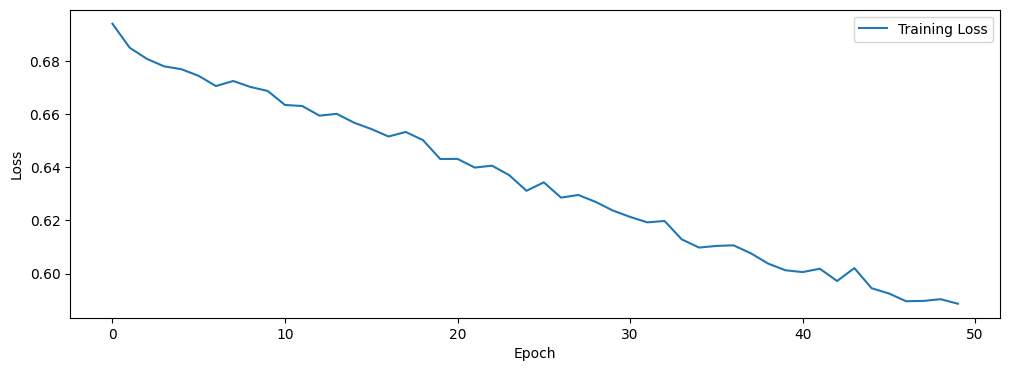

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print("Train Classification Report:")
train_predictions = [int(label) for label in predictions_train]
print(classification_report(labels_train, train_predictions))

Train Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1126
           1       0.68      0.65      0.66      1107

    accuracy                           0.67      2233
   macro avg       0.67      0.67      0.67      2233
weighted avg       0.67      0.67      0.67      2233



In [ ]:
print("Test Classification Report:")
test_predictions = [int(label) for label in predictions_test]
print(classification_report(labels_test, test_predictions))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       293
           1       0.59      0.50      0.54       266

    accuracy                           0.59       559
   macro avg       0.59      0.59      0.59       559
weighted avg       0.59      0.59      0.59       559



<p class="task" id="6"></p>

6\. Решите предыщую задачу, заменив собственный модуль `RNN` на модули `nn.RNN`, `nn.LSTM` и `nn.GRU`. Сравните результаты работы.

- [ ] Проверено на семинаре

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, rnn_type):
        super().__init__()

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = output[:, -1, :]
        output = self.fc(output)
        return output

In [ ]:
num_epochs = 50

rnn_model = RNNModel(input_size=len(train_dataset[0][0]), hidden_size=64, num_classes=classes, rnn_type='rnn')
lstm_model = RNNModel(input_size=len(train_dataset[0][0]), hidden_size=64, num_classes=classes, rnn_type='lstm')
gru_model = RNNModel(input_size=len(train_dataset[0][0]), hidden_size=64, num_classes=classes, rnn_type='gru')

criterion = nn.CrossEntropyLoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

train_loss_rnn = []
train_loss_lstm = []
train_loss_gru = []

In [ ]:
%%time
for epoch in range(num_epochs):
    rnn_model.train()
    lstm_model.train()
    gru_model.train()
    running_loss_rnn = 0.0
    running_loss_lstm = 0.0
    running_loss_gru = 0.0
    predictions_train_rnn = []
    predictions_train_lstm = []
    predictions_train_gru = []
    labels_train = []

    for indices, labels in train_loader:
        indices = indices.unsqueeze(1).to(torch.float32)
        # RNN
        output_rnn = rnn_model(indices)
        loss_rnn = criterion(output_rnn, labels)
        loss_rnn.backward()
        rnn_optimizer.step()
        rnn_optimizer.zero_grad()
        running_loss_rnn += loss_rnn.item()

        predictions_train_rnn.extend(torch.argmax(output_rnn, dim=1).tolist())
        # LSTM
        output_lstm = lstm_model(indices)
        loss_lstm = criterion(output_lstm, labels)
        loss_lstm.backward()
        lstm_optimizer.step()
        lstm_optimizer.zero_grad()
        running_loss_lstm += loss_rnn.item()

        predictions_train_lstm.extend(torch.argmax(output_lstm, dim=1).tolist())
        # GRU
        output_gru = gru_model(indices)
        loss_gru = criterion(output_gru, labels)
        loss_gru.backward()
        gru_optimizer.step()
        gru_optimizer.zero_grad()
        running_loss_gru += loss_rnn.item()

        predictions_train_gru.extend(torch.argmax(output_gru, dim=1).tolist())

        labels_train.extend(labels.tolist())

    train_loss_rnn.append(running_loss_rnn / len(train_loader))
    train_loss_lstm.append(running_loss_lstm / len(train_loader))
    train_loss_gru.append(running_loss_gru / len(train_loader))

    model.eval()
    predictions_test_rnn = []
    predictions_test_lstm = []
    predictions_test_gru = []
    labels_test = []

    with torch.no_grad():
        for indices, labels in test_loader:
            indices = indices.unsqueeze(1).to(torch.float32)
            # RNN
            output_rnn = rnn_model(indices)
            predictions_test_rnn.extend(torch.argmax(output_rnn, dim=1).tolist())
            # LSTM
            output_lstm = lstm_model(indices)
            predictions_test_lstm.extend(torch.argmax(output_lstm, dim=1).tolist())
            # GRU
            output_gru = gru_model(indices)
            predictions_test_gru.extend(torch.argmax(output_gru, dim=1).tolist())

            labels_test.extend(labels.tolist())

CPU times: user 1min 42s, sys: 743 ms, total: 1min 43s
Wall time: 1min 45s


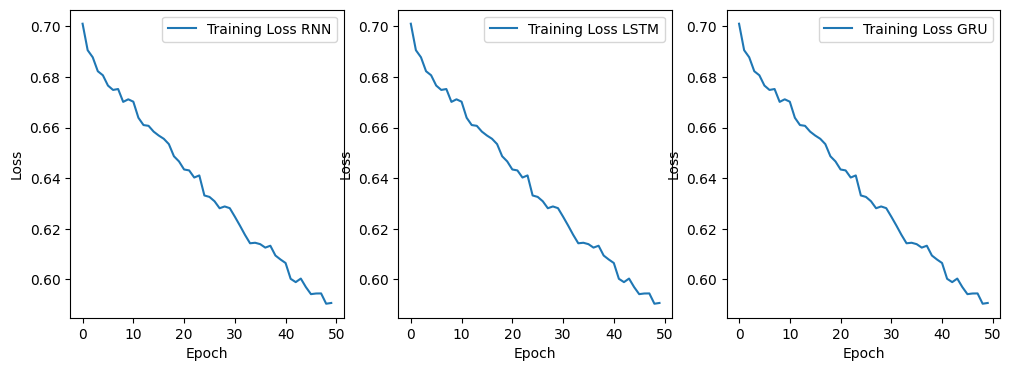

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_loss_rnn, label='Training Loss RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(train_loss_lstm, label='Training Loss LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(train_loss_gru, label='Training Loss GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print("Train Classification Report for RNN model:")
train_predictions = [int(label) for label in predictions_train_rnn]
print(classification_report(labels_train, train_predictions))

Train Classification Report for RNN model:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1126
           1       0.69      0.65      0.67      1107

    accuracy                           0.68      2233
   macro avg       0.68      0.68      0.68      2233
weighted avg       0.68      0.68      0.68      2233



In [ ]:
print("Test Classification Report for RNN model:")
test_predictions = [int(label) for label in predictions_test_rnn]
print(classification_report(labels_test, test_predictions))

Test Classification Report for RNN model:
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       293
           1       0.57      0.69      0.63       266

    accuracy                           0.61       559
   macro avg       0.61      0.61      0.61       559
weighted avg       0.62      0.61      0.61       559



In [ ]:
print("Train Classification Report for LSTM model:")
train_predictions = [int(label) for label in predictions_train_lstm]
print(classification_report(labels_train, train_predictions))

Train Classification Report for LSTM model:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1126
           1       0.71      0.68      0.69      1107

    accuracy                           0.70      2233
   macro avg       0.70      0.70      0.70      2233
weighted avg       0.70      0.70      0.70      2233



In [ ]:
print("Test Classification Report for LSTM model:")
test_predictions = [int(label) for label in predictions_test_lstm]
print(classification_report(labels_test, test_predictions))

Test Classification Report for LSTM model:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       293
           1       0.59      0.64      0.62       266

    accuracy                           0.62       559
   macro avg       0.62      0.62      0.62       559
weighted avg       0.62      0.62      0.62       559



In [ ]:
print("Train Classification Report for GRU model:")
train_predictions = [int(label) for label in predictions_train_gru]
print(classification_report(labels_train, train_predictions))

Train Classification Report for GRU model:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1126
           1       0.72      0.67      0.70      1107

    accuracy                           0.71      2233
   macro avg       0.71      0.71      0.71      2233
weighted avg       0.71      0.71      0.71      2233



In [ ]:
print("Test Classification Report for GRU model:")
test_predictions = [int(label) for label in predictions_test_gru]
print(classification_report(labels_test, test_predictions))

Test Classification Report for GRU model:
              precision    recall  f1-score   support

           0       0.64      0.56      0.60       293
           1       0.58      0.66      0.62       266

    accuracy                           0.61       559
   macro avg       0.61      0.61      0.61       559
weighted avg       0.61      0.61      0.61       559



## Обратная связь
- [ ] Хочу получить обратную связь по решению